# Born

## Import modules

In [1]:
# Basic stuff
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

# Plotting library
import matplotlib.pyplot as plt
import sepPlot

## Wavelet (sources)

In [2]:
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/waveletMain.py nts=1000 dts=0.008 timeDelay=1.0 f1=2 f2=5 f3=8 f4=15 type=ali wavelet=wlt.H
!Spectra < wlt.H | Graph grid=y title="Wavelet spectrum" max1=30 label1="Frequency [Hz]" | Xtpen 
!Graph grid=y max1=2.0 title="Wavelet" < wlt.H | Xtpen 

## Velocity models

In [3]:
# True velocity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

# Background velocity model
!Smooth rect1=10 rect2=10 < velocityMarmousi.H > background.H
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=background.H data=background.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Model (reflectivity)

In [4]:
# Reflectivity model
!Add velocityMarmousi.H background.H scale=1,-1 > BornModel.H

# Pad reflectivity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=BornModel.H data=BornModel.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Initialize Born operator

In [5]:
args=["dummy arg","vel=background.pad.H","sources=wlt.H","par=parPythonTest.p","model=BornModel.pad.H"]
modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector=Acoustic_iso_double.BornOpInitDouble(args)

# Printing parameter file for reference
!cat parPythonTest.p

nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=2
xSource=1
nShot=170
spacingShots=10
depthReceiver=2
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


## Create Born operator

In [6]:
BornOp=Acoustic_iso_double.BornShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)

## Read model

In [7]:
modelFile=parObject.getString("model")
modelFloat=genericIO.defaultIO.getVector("modelFile",ndims=2)
modelDouble=SepVector.getSepVector(modelFloat.getHyper(),storage="dataDouble")
modelDMat=modelDouble.getNdArray()
modelSMat=modelFloat.getNdArray()
modelDMat[:]=modelSMat

## Plot velocity models

### Background model

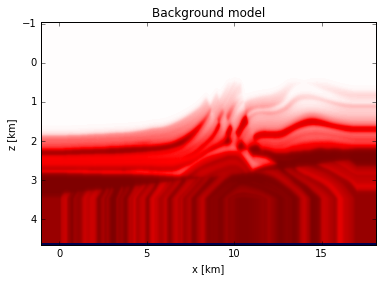

In [15]:
sepPlot.Grey(plt,velDouble,label1="z [km]",label2="x [km]",color="F",title="Background model").output()

### True reflectivity

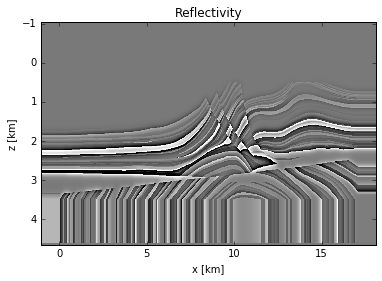

In [9]:
sepPlot.Grey(plt,modelDouble,label1="z [km]",label2="x [km]",title="Reflectivity").output()

## Born forward

In [10]:
start=time.time()
BornOp.forward(False,modelDouble,dataDouble)
end=time.time()
print("Computational time for forward = ",end-start," [s]")

Computational time for forward =  78.747638463974  [s]


## Born adjoint

In [11]:
# Create a model vector for adjoint result
modelAdjDouble=SepVector.getSepVector(modelDouble.getHyper(),storage="dataDouble")

# Apply adjoint
start=time.time()
BornOp.adjoint(False,modelAdjDouble,dataDouble)
end=time.time()
print("Computational time for adjoint = ",end-start," [s]")

Computational time for adjoint =  81.0936062335968  [s]


## Display results

### Model

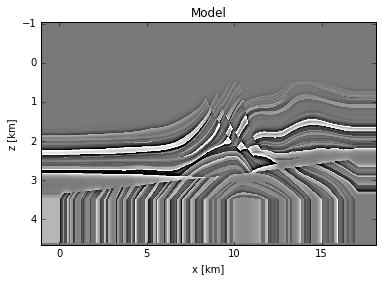

In [12]:
# Plot model
sepPlot.Grey(plt,modelDouble,label1="z [km]",label2="x [km]",title="Model").output()

### Forward

In [13]:
# Convert data to 2D float 
dataFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble.getHyper().axes[0],dataDouble.getHyper().axes[1]]))
dataFloat2DNd=dataFloat2D.getNdArray()
dataDoubleNd=dataDouble.getNdArray()
dataFloat2DNd[:]=dataDoubleNd

# Plot forward
sepPlot.Grey(plt,dataFloat2D,label1="Time [s]",label2="Receivers [km]",title="Forward").output()

ValueError: could not broadcast input array from shape (170,1700,1000) into shape (1700,1000)

### Adjoint

In [ ]:
# Plot adjoint
sepPlot.Grey(plt,modelAdjDouble,label1="z [km]",label2="x [km]",title="Model").output()

## Write results to disk

In [ ]:
# Data 
dataFloat=SepVector.getSepVector(dataDouble.getHyper(),storage="dataFloat")
dataFloatNp=dataFloat.getNdArray()
dataDoubleNp=dataDouble.getNdArray()
dataFloatNp[:]=dataDoubleNp
_=genericIO.defaultIO.writeVector("BornFwdJupyter.H",modelFloat)

# Model after applying FWD and ADJ
modelFloat=SepVector.getSepVector(modelAdjDouble.getHyper(),storage="dataFloat")
modelFloatNp=modelAdjDouble.getNdArray()
modelDoubleNp=modelAdjDouble.getNdArray()
modelFloatNp[:]=modelDoubleNp
_=genericIO.defaultIO.writeVector("BornAdjJupyter.H",modelFloat)

# Dot product test

In [ ]:
BornOp.dotTest(True)